In [1]:
import os
import sys
import argparse
from os.path import dirname, realpath


In [2]:
sys.path.append("./src/")
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

In [4]:
%run load_Results.py

In [52]:
wt00 = np.where(gold0 == 1, 1/.064, 1)

In [514]:
np.mean(gold0)

0.019012527634487842

In [ ]:
# this is best so far,.default
#wts01 = np.where(gold1 == 1, 1/.064, 1)
#wts02 = np.where(gold2 == 1, 2/.064, 2)
#wts03 = np.where(gold3 == 1, 3/.064, 3)
#wts04 = np.where(gold4 == 1, 4/.064, 4)

In [661]:
wts01 = np.where(gold1 == 1, 1/np.sqrt(.064*np.mean(gold1)), 1)
wts02 = np.where(gold2 == 1, 2/np.sqrt(.064*np.mean(gold2)), 2)
wts03 = np.where(gold3 == 1, 3/np.sqrt(.064*np.mean(gold3)), 3)
wts04 = np.where(gold4 == 1, 4/np.sqrt(.064*np.mean(gold4)), 4)

In [432]:
#wts01 = np.where(gold1 == 1, 1/np.mean(gold1), 1)
#wts02 = np.where(gold2 == 1, 2/np.mean(gold2), 2)
#wts03 = np.where(gold3 == 1, 3/np.mean(gold3), 3)
#wts04 = np.where(gold4 == 1, 4/np.mean(gold4), 4)

In [740]:
wts01 = np.where(gold1 == 1, 1/(np.mean(gold1)*mp1), 1/mp1 )
wts02 = np.where(gold2 == 1,2/(np.mean(gold2)*mp2), 2/mp2 )
wts03 = np.where(gold3 == 1,3/(np.mean(gold3)*mp3), 3/mp3 )
wts04 = np.where(gold4 == 1,4/(np.mean(gold4)*mp4), 4/mp4 )

In [741]:
wts1234 = np.concatenate((wts01,wts02, wts03, wts04))
y1234 = np.concatenate((gold1,gold2, gold3, gold4))
lo1234 = logit( np.concatenate((mp1,mp2, mp3, mp4)) )
tlo1234 = logit( np.concatenate((tp1,tp2, tp3, tp4)) )

time_index = np.concatenate((np.ones(len(mp1)), 2*np.ones(len(mp2)), 3*np.ones(len(mp3)), 4*np.ones(len(mp4))))
test_time_index = np.concatenate((np.ones(len(tp1)), 2*np.ones(len(tp2)), 3*np.ones(len(tp3)), 4*np.ones(len(tp4))))

In [742]:
def weighted_temp2_scaling (logits, y, wts):
    def temperature_obj(t):
        temp_logits =   (logits ) /  t [0] + t[1]
        probs = expit(temp_logits)
        return log_loss(y, probs, sample_weight=wts)    
    res = minimize (temperature_obj,x0 = [.1,.1])
    return res.x

In [743]:
alpha_0_1234  = weighted_temp2_scaling(  lo1234 , y1234,  wts1234)


In [744]:
def temp_pred2 (alpha,  test_logit):    
    logi =  (test_logit )/ alpha[0]      + alpha[1]
    proba = expit ( logi  )              #*tt.x[5]    
    return proba

In [745]:
cal_0_1234 = temp_pred2(alpha_0_1234, lo1234 )

In [746]:
cal_t_1234 = temp_pred2(alpha_0_1234, tlo1234 )

(array([1559., 5152., 6681., 7477., 7403., 7497., 7665., 6590., 3938.,
         906.]),
 array([0.14733013, 0.22044424, 0.29355835, 0.36667246, 0.43978656,
        0.51290067, 0.58601478, 0.65912889, 0.732243  , 0.8053571 ,
        0.87847121]),
 <BarContainer object of 10 artists>)

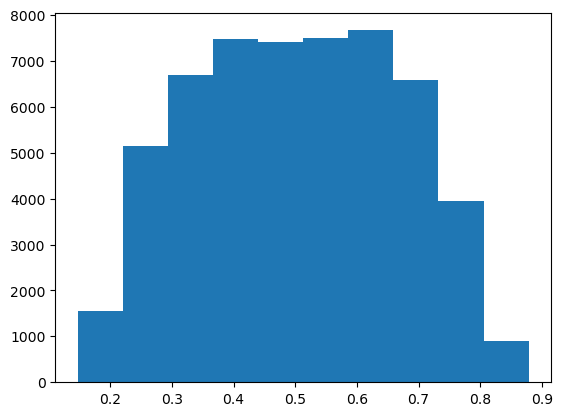

In [747]:
plt.hist(cal_t_1234)

In [748]:
w01 = 1/cal_0_1234 [time_index==1]
w02 = 1/cal_0_1234 [time_index==2]
w03 = 1/cal_0_1234 [time_index==3]
w04 = 1/cal_0_1234 [time_index==4]

In [749]:
wts1 = np.where(gold1 == 1, w01/np.mean(gold1), w01)
wts2 = np.where(gold2 == 1, w02/np.mean(gold2), w02)
wts3 = np.where(gold3 == 1, w03/np.mean(gold3), w03)
wts4 = np.where(gold4 == 1, w04/np.mean(gold4), w04)

In [750]:
def temperature_multi_w(l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1 +  t[1])  / t[5] 
        logi_2 = (l2 +  t[2])  / t[6] 
        logi_3 = (l3 +  t[3])  / t[7] 
        logi_4 = (l4 +  t[4])  / t[8] 
        
        p1  = expit (t[0] *  logi_1  )  
        p2  = expit ( t[0] *  logi_2  )  
        p3  = expit (t[0] *  logi_3  )  
        p4  = expit ( t[0] * logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1, .1,.1, .1,.1  ] )    
    return  r

In [751]:
tt  = temperature_multi_w( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [752]:
def temp_pred  ( j1,j2, test_logit):    
    logi =  ( test_logit   + j1) / j2     
    proba = expit (  logi *tt.x[0]  )  
    return proba

In [762]:
cal_1 = temp_pred(tt.x[1],tt.x[5], logit(tp1) )
cal_2 = temp_pred(tt.x[2],tt.x[6], logit(tp2) )
cal_3 = temp_pred(tt.x[3],tt.x[7], logit(tp3) )
cal_4 = temp_pred(tt.x[4],tt.x[8], logit(tp4) )

y1, p1 = calibration_curve(M_test1['golds'], cal_1 , n_bins = 1000)
y2, p2 = calibration_curve(M_test2['golds'], cal_2 , n_bins = 1000)
y3, p3 =calibration_curve(M_test3['golds'], cal_3 , n_bins = 500)
y4, p4 = calibration_curve(M_test4['golds'], cal_4 , n_bins = 300)



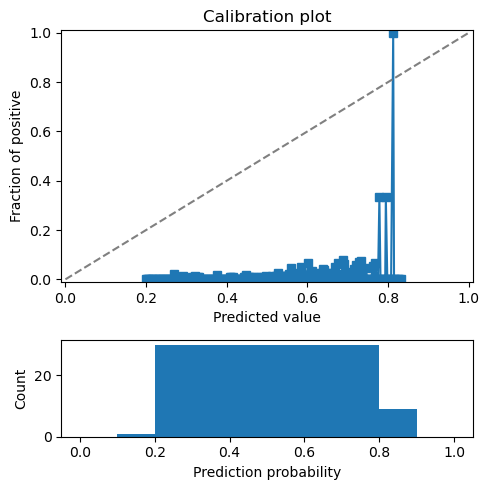

In [763]:
plotter(p4, y4)

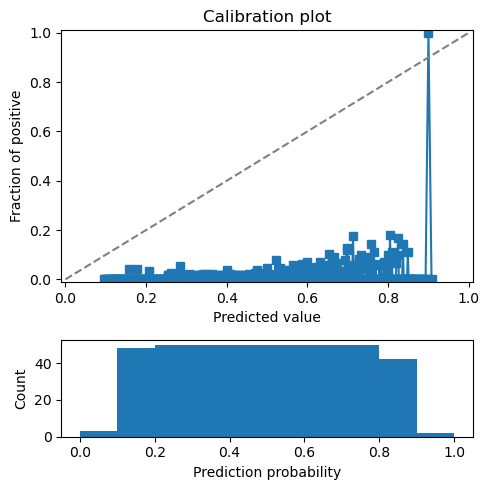

In [755]:
plotter(p3, y3)

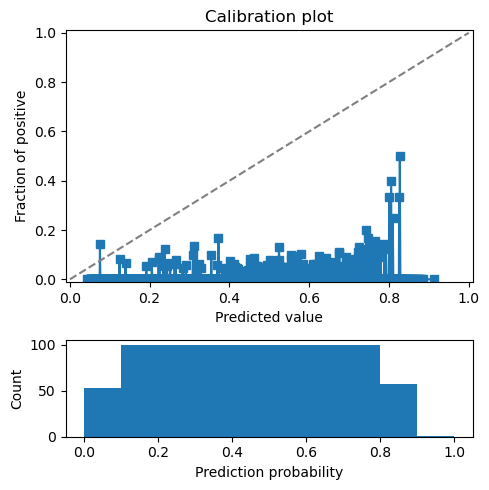

In [756]:
plotter(p2, y2)

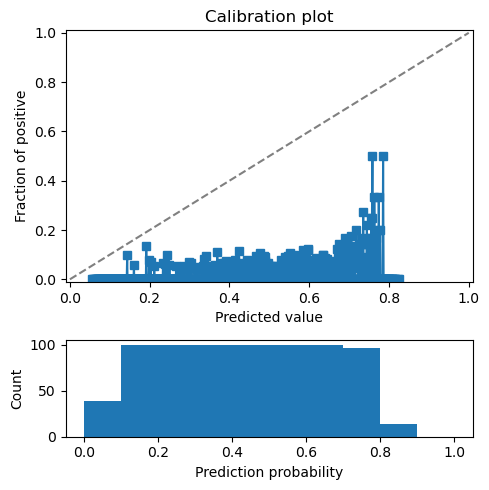

In [757]:
plotter(p1, y1)

In [163]:
tt5  = temperature_multi_5( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [164]:
def temp_pred5  ( j1, test_logit):    
    logi =  ( test_logit   + j1)   
    proba = expit (  logi / tt.x[0]  )  
    return proba

In [20]:
import sklearn
from sklearn.metrics import confusion_matrix

In [224]:
sklearn.metrics.roc_auc_score(tgold3,  tc3 , average = 'samples')


sklearn.metrics.roc_auc_score(tgold4,  tc4 , average = 'samples')


sklearn.metrics.roc_auc_score(tgold1,  tc1 , average = 'samples')


In [226]:
( confusion_matrix (tgold1,  tc1>.5) )

array([[8111, 7408],
       [ 145,  361]], dtype=int64)

In [227]:
( confusion_matrix (tgold2,  tc2>.5) )

array([[12250,  1605],
       [  149,    50]], dtype=int64)

In [228]:
( confusion_matrix (tgold3,  tc3>.5) )

array([[12405,    42],
       [  130,     2]], dtype=int64)

In [229]:
( confusion_matrix (tgold4,  tc4>.5) )

array([[10584,   128],
       [   94,     4]], dtype=int64)

In [231]:
( confusion_matrix (tgold1,  tp1>.05) )

array([[ 1657, 13862],
       [   10,   496]], dtype=int64)

In [227]:
( confusion_matrix (tgold2,  tc2>.5) )

array([[12250,  1605],
       [  149,    50]], dtype=int64)

In [228]:
( confusion_matrix (tgold3,  tc3>.5) )

array([[12405,    42],
       [  130,     2]], dtype=int64)

In [229]:
( confusion_matrix (tgold4,  tc4>.5) )

array([[10584,   128],
       [   94,     4]], dtype=int64)